# Tarea 1 INF 395

Para las tareas se utilizará `Keras`, una libreria de Deep Learning de alto nivel para Python, con el reciente anuncio de Keras Core, uno puede escoger el backend de su preferencia, ya sea Pytorch, Tensorflow o JAX.

Para más Información pueden revisar la documentación oficial de Keras: https://keras.io/

In [ ]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
#pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install -q keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 14.3 MB/s eta 0:00:00


## Integrantes:

* Nombre: Renato Burgos
* Nombre: Etienne Rojas
* Nombre: Diego Varela

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


## Helper Functions

In [ ]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [ ]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

## Parte 1: Demostración del uso de Keras

### 1.1 Mnist

Mnist es un dataset de imágenes de dígitos escritos a mano. Cada imagen es de 28x28 pixeles y está en escala de grises. El dataset está dividido en 60.000 imágenes de entrenamiento y 10.000 imágenes de testeo.

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Exploración de los Datos

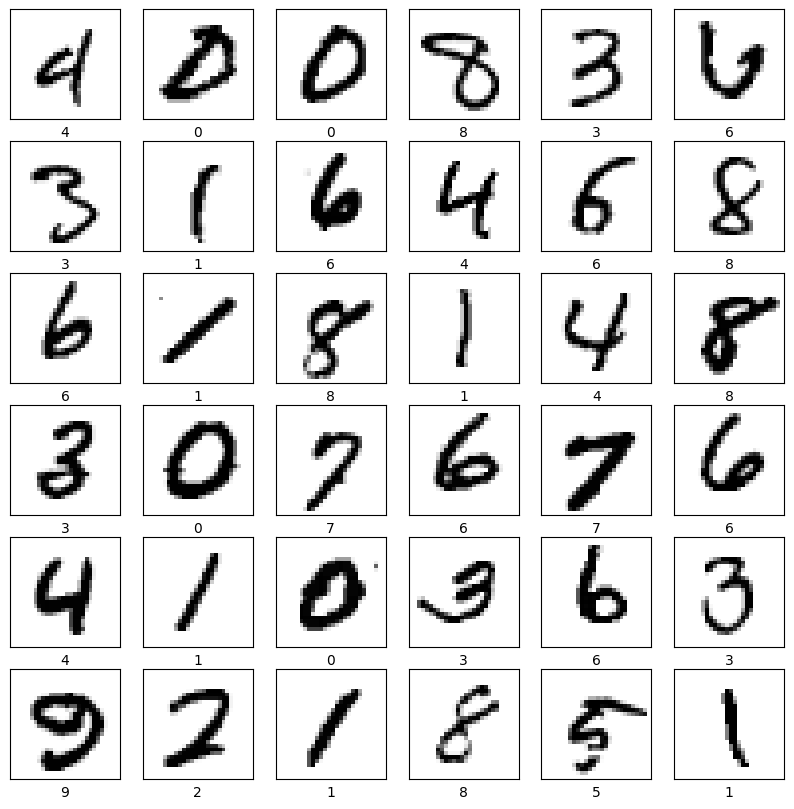

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

cantidad de clases: 10
Dimension de los datos: (28, 28)


#### One Hot Encoding

In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [5 0 4 ... 5 6 8]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#### Arquitectura de la red

In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

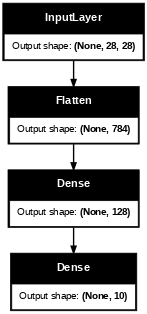

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

#### Definición de hiperparámetros

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128        #cantidad de imágenes por batch
epochs = 20             #cantidad de epochs
validation_split = 0.2  #Porcentaje de data destinada a validación

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#### Entrenamiento del Modelo

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6077 - loss: 17.2967 - val_accuracy: 0.7898 - val_loss: 1.0557
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7962 - loss: 0.9616 - val_accuracy: 0.8378 - val_loss: 0.7853
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8409 - loss: 0.6901 - val_accuracy: 0.8591 - val_loss: 0.6569
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8647 - loss: 0.5500 - val_accuracy: 0.8724 - val_loss: 0.5855
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8799 - loss: 0.4683 - val_accuracy: 0.8839 - val_loss: 0.5360
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8914 - loss: 0.4117 - val_accuracy: 0.8911 - val_loss: 0.5022
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9014 - loss: 0.3691 - val_accuracy: 0.8976 - val_loss: 0.4756
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9085 - loss: 0.3359 - val_accuracy

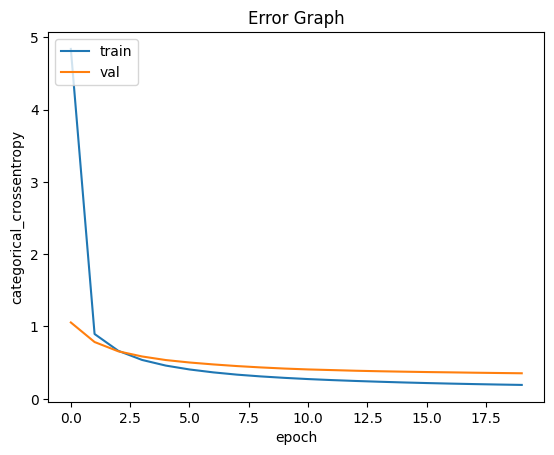

In [ ]:
plot_losses(history, loss)

#### Evaluación del Modelo

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3680489659309387
Test accuracy: 0.9214000105857849


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


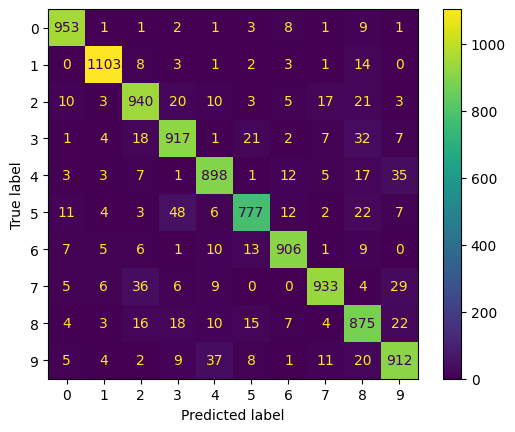

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

### 1.2.1 Cifar10

Cifar10 es un dataset de imágenes de 32x32 pixeles, que contiene 10 clases distintas. Este dataset es muy utilizado para probar algoritmos de clasificación de imágenes. En este caso, utilizaremos una versión reducida de este dataset, que contiene 50000 imágenes de entrenamiento y 10000 imágenes de testeo, con 100 imágenes por clase. Las clases son: 'avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco' y 'camión'.

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
#Visualizamos si el dataset es balanceado o no.
pd.value_counts(pd.Series(y_train.reshape(-1)))

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
dtype: int64

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


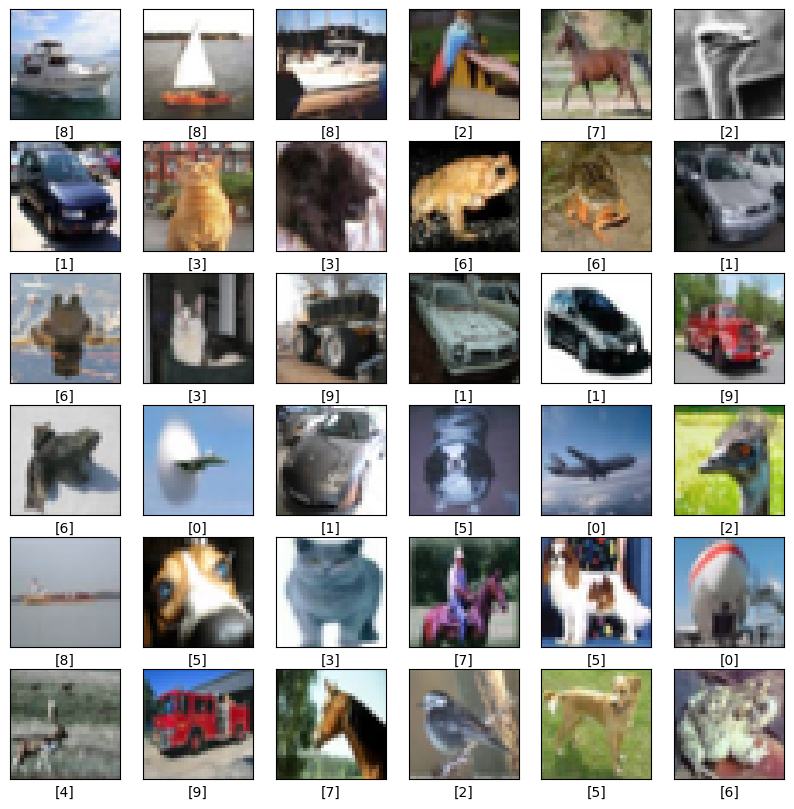

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de imágenes:',x_train.shape[0])
print('Dimensión de los datos:',input_shape)
print('Tipo de Datos:',x_train.dtype)
print('cantidad de clases:', num_classes)

cantidad de imágenes: 50000
Dimensión de los datos: (32, 32, 3)
Tipo de Datos: uint8
cantidad de clases: 10


In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    393,344 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

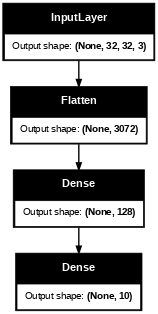

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128
epochs = 20
validation_split = 0.2

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1003 - loss: 705.6591 - val_accuracy: 0.0959 - val_loss: 2.3140
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1019 - loss: 2.3042 - val_accuracy: 0.0957 - val_loss: 2.3127
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1021 - loss: 2.3019 - val_accuracy: 0.0956 - val_loss: 2.3114
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1020 - loss: 2.3013 - val_accuracy: 0.0955 - val_loss: 2.3114
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1023 - loss: 2.3010 - val_accuracy: 0.0956 - val_loss: 2.3119
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1023 - loss: 2.3009 - val_accuracy: 0.0956 - val_loss: 2.3117
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1023 - loss: 2.3007 - val_accuracy: 0.0957 - val_loss: 2.3117
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1022 - loss: 2.3007 - val_accuracy:

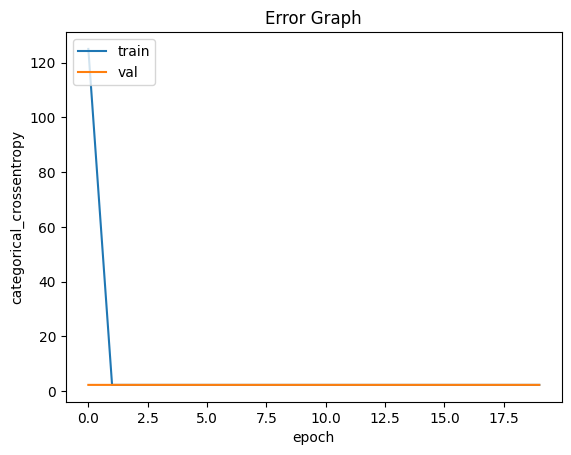

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.309175729751587
Test accuracy: 0.09969999641180038


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


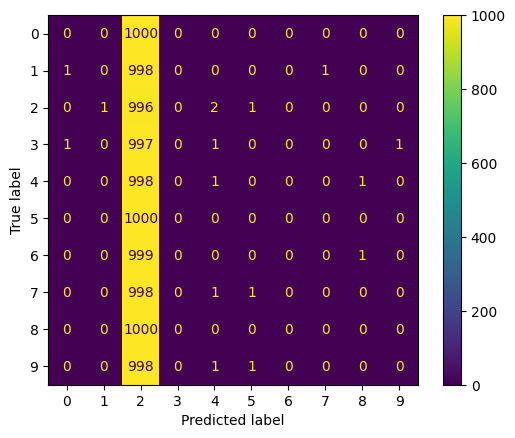

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
# Comparamos otras métricas de clasificación como la precisión, recall y f1-score
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1000
     class 1       0.00      0.00      0.00      1000
     class 2       0.10      1.00      0.18      1000
     class 3       0.00      0.00      0.00      1000
     class 4       0.17      0.00      0.00      1000
     class 5       0.00      0.00      0.00      1000
     class 6       0.00      0.00      0.00      1000
     class 7       0.00      0.00      0.00      1000
     class 8       0.00      0.00      0.00      1000
     class 9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos observar como este simple modelo de redes neuronales no es lo suficientemente capaz de clasificar las imágenes, de hecho les asigna el mismo label a todas las imágenes.

Es por esto que saltan los warnings, porque al calcular f1, recall y precisión, no hay datos para las otras clases.

Ahora vamos a ver como podemos mejorar nuestro modelo.

### 1.2.2 Mejorando el Modelo

In [ ]:
#Es una práctica común en modelos de machine learning escalar nuestros datos, asi nos aseguramos de que todos tengan el mismo rango, con pequeños cambios como estos nuestros modelos pueden mejorar su desempeño.

#Escalamos las imágenes entre [0,1]
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 512)               │  1,573,376 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,748,266 (6.67 MB)

 Trainable params: 1,748,266 (6.67 MB)

 Non-trainable params: 0 (0.00 B)

**Explique cómo funciona la capa de Dropout dentro del modelo y por qué esta capa mejora las predicciones [3pts]**

`Respuesta: Es una capa en la que se desactivan ciertas neuronas, de forma estocastica (con probabilidad 0.1 en este caso) con el objetivo de forzar al modelo a no depender de ciertas conexiones y evitar el overfitting.`

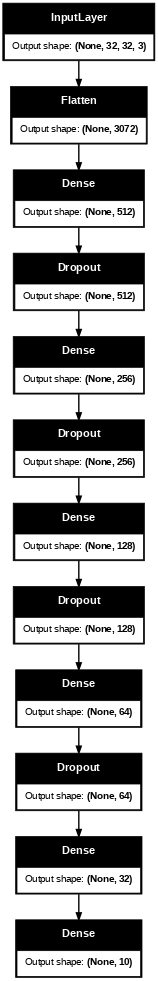

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Agregamos Callbacks
#Early Stopping monitorea la función de pérdida y detiene el entrenamiento cuando no hay mejora dentro de un número de épocas determinado, lo que nos ahorra tiempo de entrenamiento y también evita el sobreajuste.
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
#Cambiamos el Optimizador a Adam
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.Adam(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# agregamos más epoochs ahora que tenemos early stopping
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.1602 - loss: 2.2486 - val_accuracy: 0.3037 - val_loss: 1.9452
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2929 - loss: 1.9177 - val_accuracy: 0.3428 - val_loss: 1.8358
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3326 - loss: 1.8299 - val_accuracy: 0.3618 - val_loss: 1.7742
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3515 - loss: 1.7849 - val_accuracy: 0.3854 - val_loss: 1.7102
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3678 - loss: 1.7421 - val_accuracy: 0.3976 - val_loss: 1.6913
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3834 - loss: 1.7141 - val_accuracy: 0.3982 - val_loss: 1.6718
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3968 - loss: 1.6796 - val_accuracy: 0.4205 - val_loss: 1.6209
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3998 - loss: 1.6540 - val_a

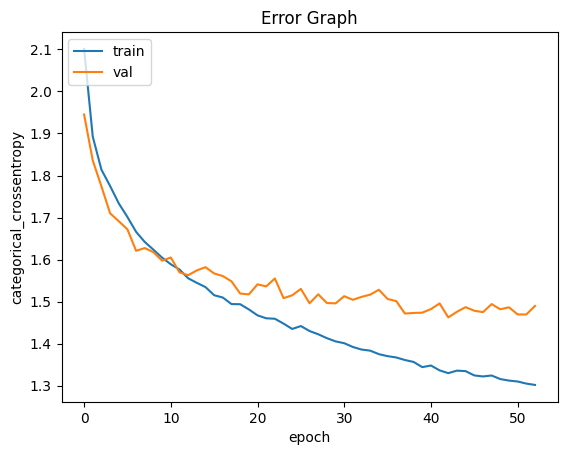

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4485288858413696
Test accuracy: 0.4839000105857849


Aún estamos con un accuracy del 0.5, eso seria equivalente a lanzar una moneda al aire y que salga cara o sello, por lo que no es un buen modelo, pero se puede mejorar.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


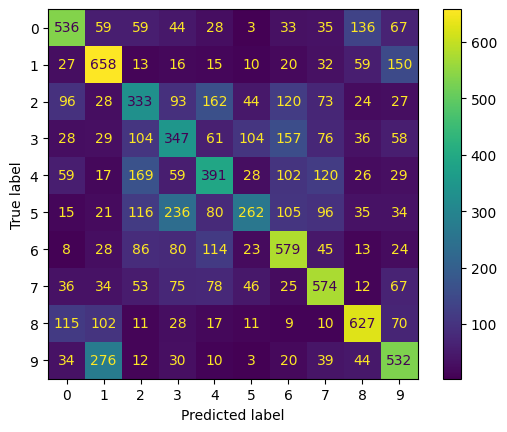

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.54      0.55      1000
     class 1       0.53      0.66      0.58      1000
     class 2       0.35      0.33      0.34      1000
     class 3       0.34      0.35      0.35      1000
     class 4       0.41      0.39      0.40      1000
     class 5       0.49      0.26      0.34      1000
     class 6       0.49      0.58      0.53      1000
     class 7       0.52      0.57      0.55      1000
     class 8       0.62      0.63      0.62      1000
     class 9       0.50      0.53      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



### 1.2.3 Último Modelo ahora Con Convoluciones y Skip Connections

Keras nos permite complejizar el modelo de una manera muy sencilla, agregaremos capas convolucionales, ya que estas son muy buenas a la hora de trabajar con imágenes, también agregaremos skip connections que son conexiones que se saltan capas del modelo.

**EJEMPLO DE SKIP CONNECTION**

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png">

**¿Qué problema resuelven las Skip Connections y como lo hacen? [3pts]**


`Respuesta: Al aumentar las capas de una red, se empieza a sufrir el problema del desvanecimiento del gradiente, ya que en el backpropagation el gradiente va acercandose a cero, añadiendo conexiones que se saltan capas (skip conections) se mitiga este problema.`


In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)
flatten_x1 = keras.layers.Flatten()(x_1)

x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)
flatten_x2 = keras.layers.Flatten()(x_2)

x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_3)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_3)
x_3 = keras.layers.Dropout(0.2)(x_3)
flatten_x3 = keras.layers.Flatten()(x_3)

z = keras.layers.concatenate([flatten_x1, flatten_x2])
z = keras.layers.concatenate([z, flatten_x3])

z =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(z)
outputs = keras.layers.Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     896 │ input_layer_3[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 32, 32,    │     128 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │   9,248 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │       0 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  18,496 │ dropout_4[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  36,928 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │       0 │ batch_normalization… │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8, 64)  │       0 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │  73,856 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │ 147,584 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_5[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │       0 │ batch_normalization

 Total params: 7,804,234 (29.77 MB)

 Trainable params: 7,803,338 (29.77 MB)

 Non-trainable params: 896 (3.50 KB)

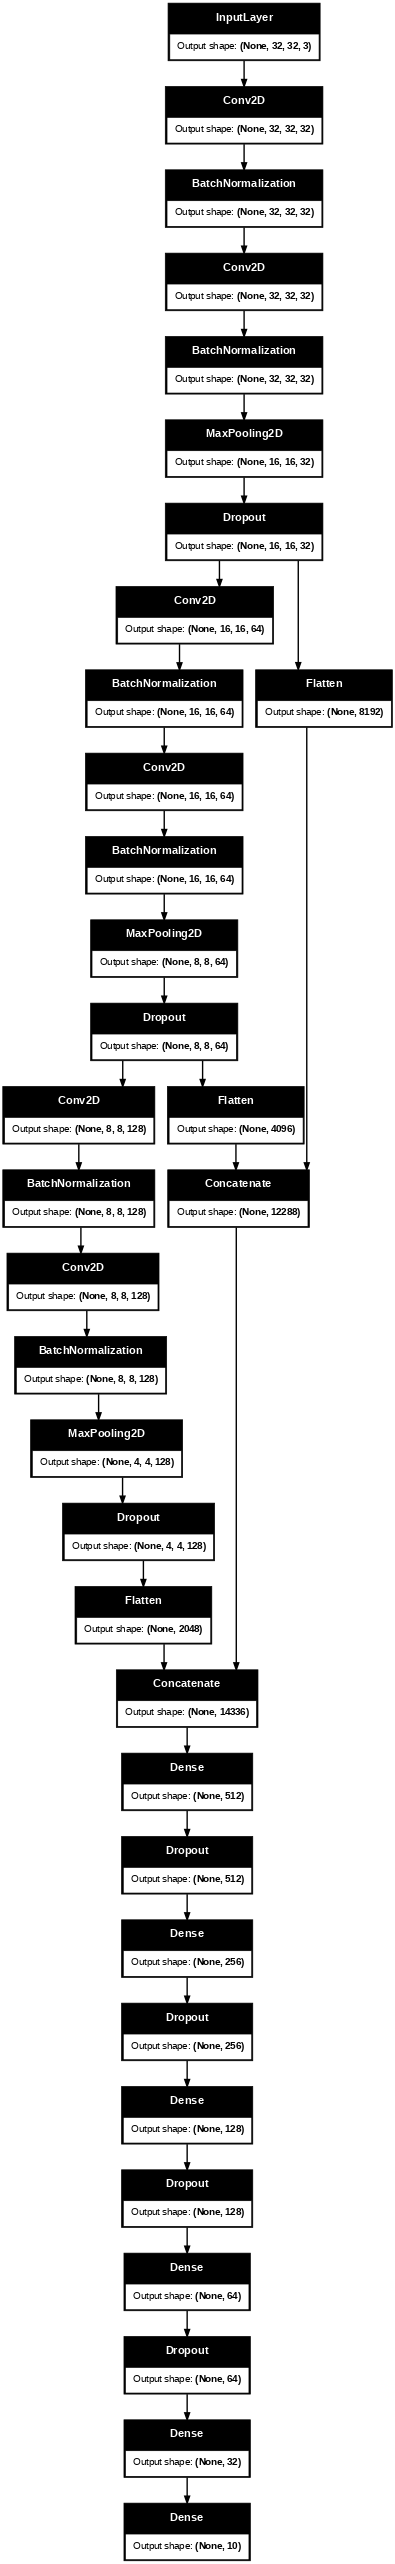

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Cambiamos el Optimizador a AdamW
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [ ]:
#Early Stopping
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
# Hiperparámetros
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.2358 - loss: 2.6613 - val_accuracy: 0.3053 - val_loss: 1.8469
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4763 - loss: 1.4582 - val_accuracy: 0.5827 - val_loss: 1.2056
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5929 - loss: 1.1617 - val_accuracy: 0.6703 - val_loss: 0.9719
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6732 - loss: 0.9544 - val_accuracy: 0.7060 - val_loss: 0.8747
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7245 - loss: 0.8009 - val_accuracy: 0.7097 - val_loss: 0.8677
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7763 - loss: 0.6671 - val_accuracy: 0.7466 - val_loss: 0.8073
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8089 - loss: 0.5674 - val_accuracy: 0.7592 - val_loss: 0.7897
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8390 - loss: 0.48

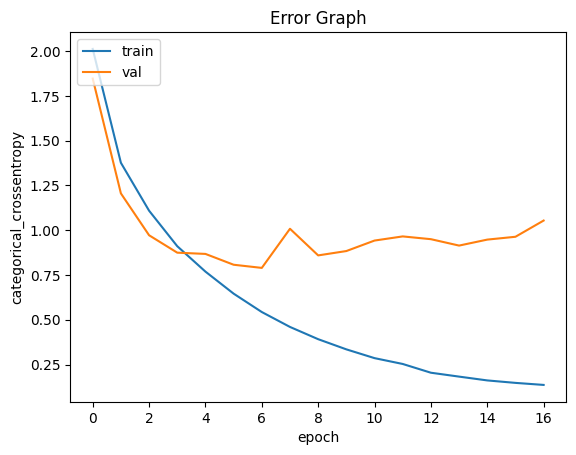

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.824028730392456
Test accuracy: 0.7468000054359436


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


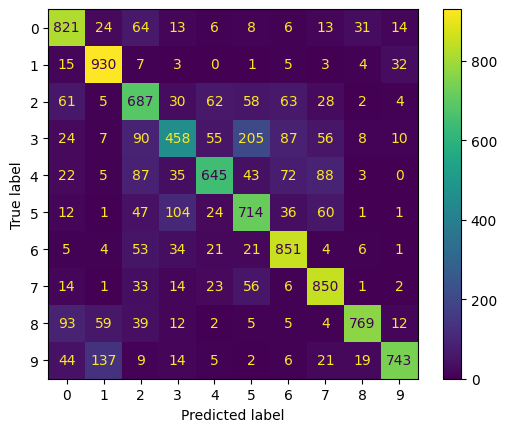

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.74      0.82      0.78      1000
     class 1       0.79      0.93      0.86      1000
     class 2       0.62      0.69      0.65      1000
     class 3       0.64      0.46      0.53      1000
     class 4       0.77      0.65      0.70      1000
     class 5       0.64      0.71      0.68      1000
     class 6       0.75      0.85      0.80      1000
     class 7       0.75      0.85      0.80      1000
     class 8       0.91      0.77      0.83      1000
     class 9       0.91      0.74      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000



Ahora ya tenemos resultados aceptables, pero esta no es la única forma de mejorar nuestro modelo, si ya conocemos alguna arquitectura del estado del arte para nuestra tarea podemos simplemente importar un modelo, congelarlo y reemplazar la última capa para que se ajuste a nuestro problema. Esto se llama `Transfer Learning` y es una de las formas más usadas para entrenar redes neuronales en la actualidad, ya que nos ahorra mucho tiempo de entrenamiento y nos permite usar modelos que ya han sido probados y que sabemos que funcionan bien.

### 1.2.4 Transfer Learning

In [ ]:
pre_trained_mobilenet = keras.applications.VGG16(input_shape=input_shape,include_top=False) #Cargamos la red pre-entrenada, sin la capa densa final, ya que queremos adaptar esta red a nuestro dataset.

#Agregamos una capa de GlobalAveragePooling2D para reducir la dimensionalidad de la salida de la red pre-entrenada y la capa de salida.
x = pre_trained_mobilenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=pre_trained_mobilenet.input, outputs=outputs)

for layer in pre_trained_mobilenet.layers: #Tenemos que explicitar que no queremos entrenar las capas de la red pre-entrenada.
    layer.trainable = False

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

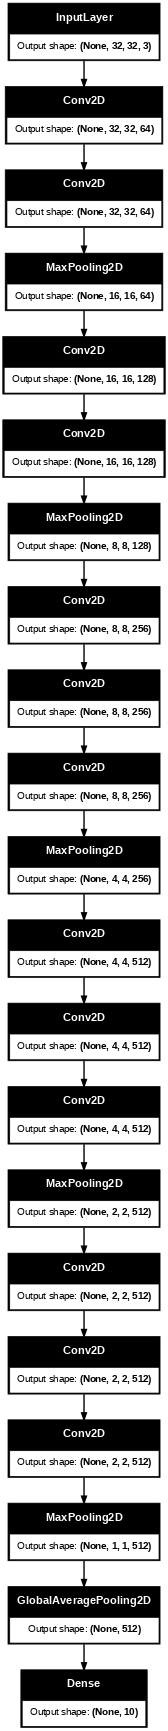

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Cambiamos el Optimizador
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.2907 - loss: 2.0249 - val_accuracy: 0.4853 - val_loss: 1.5376
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5002 - loss: 1.4875 - val_accuracy: 0.5189 - val_loss: 1.4136
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5312 - loss: 1.3800 - val_accuracy: 0.5375 - val_loss: 1.3556
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5509 - loss: 1.3241 - val_accuracy: 0.5481 - val_loss: 1.3198
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5632 - loss: 1.2874 - val_accuracy: 0.5561 - val_loss: 1.2950
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5717 - loss: 1.2607 - val_accuracy: 0.5617 - val_loss: 1.2768
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5779 - loss: 1.2400 - val_accuracy: 0.5663 - val_loss: 1.2627
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5832 - loss: 1.22

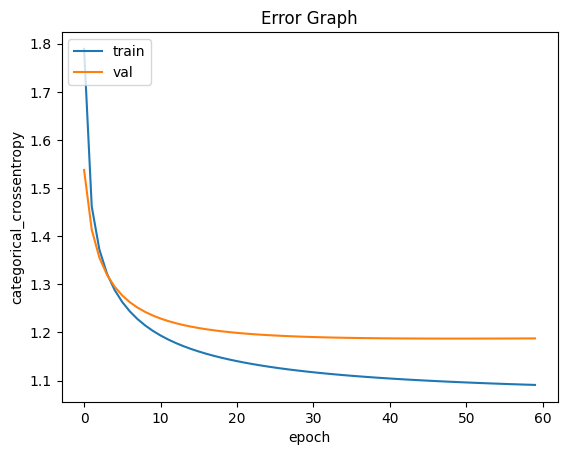

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1918491125106812
Test accuracy: 0.5856999754905701


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


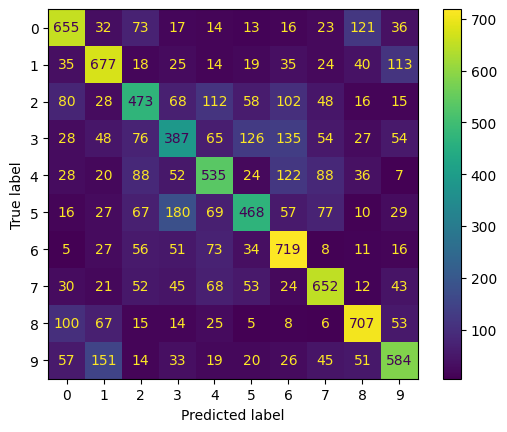

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.63      0.66      0.64      1000
     class 1       0.62      0.68      0.65      1000
     class 2       0.51      0.47      0.49      1000
     class 3       0.44      0.39      0.41      1000
     class 4       0.54      0.54      0.54      1000
     class 5       0.57      0.47      0.51      1000
     class 6       0.58      0.72      0.64      1000
     class 7       0.64      0.65      0.64      1000
     class 8       0.69      0.71      0.70      1000
     class 9       0.61      0.58      0.60      1000

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000



Podemos observar cómo no obtenemos resultados tan buenos como la red anterior pero hay que tener en cuenta que implementamos una arquitectura en menos de 5 lineas, desde cargar el modelo, agregar una capa de max pooling y finalmente la capa de salida.

## Parte 2: Datset Guiado

### 2.1 Exploracion de la Data

In [ ]:
df = pd.read_csv('Steel_industry_data.csv')

In [ ]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


Siempre es bueno revisar los datos que tenemos, ver si existen datos faltantes, el tipo de dato de cada columna, etc.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

**Realice un pequeño EDA (Exploratory Data Analisys) del Dataset, mostrando algunos gráficos como el que se presenta a continuación, y comente lo que observa. [3pts]**

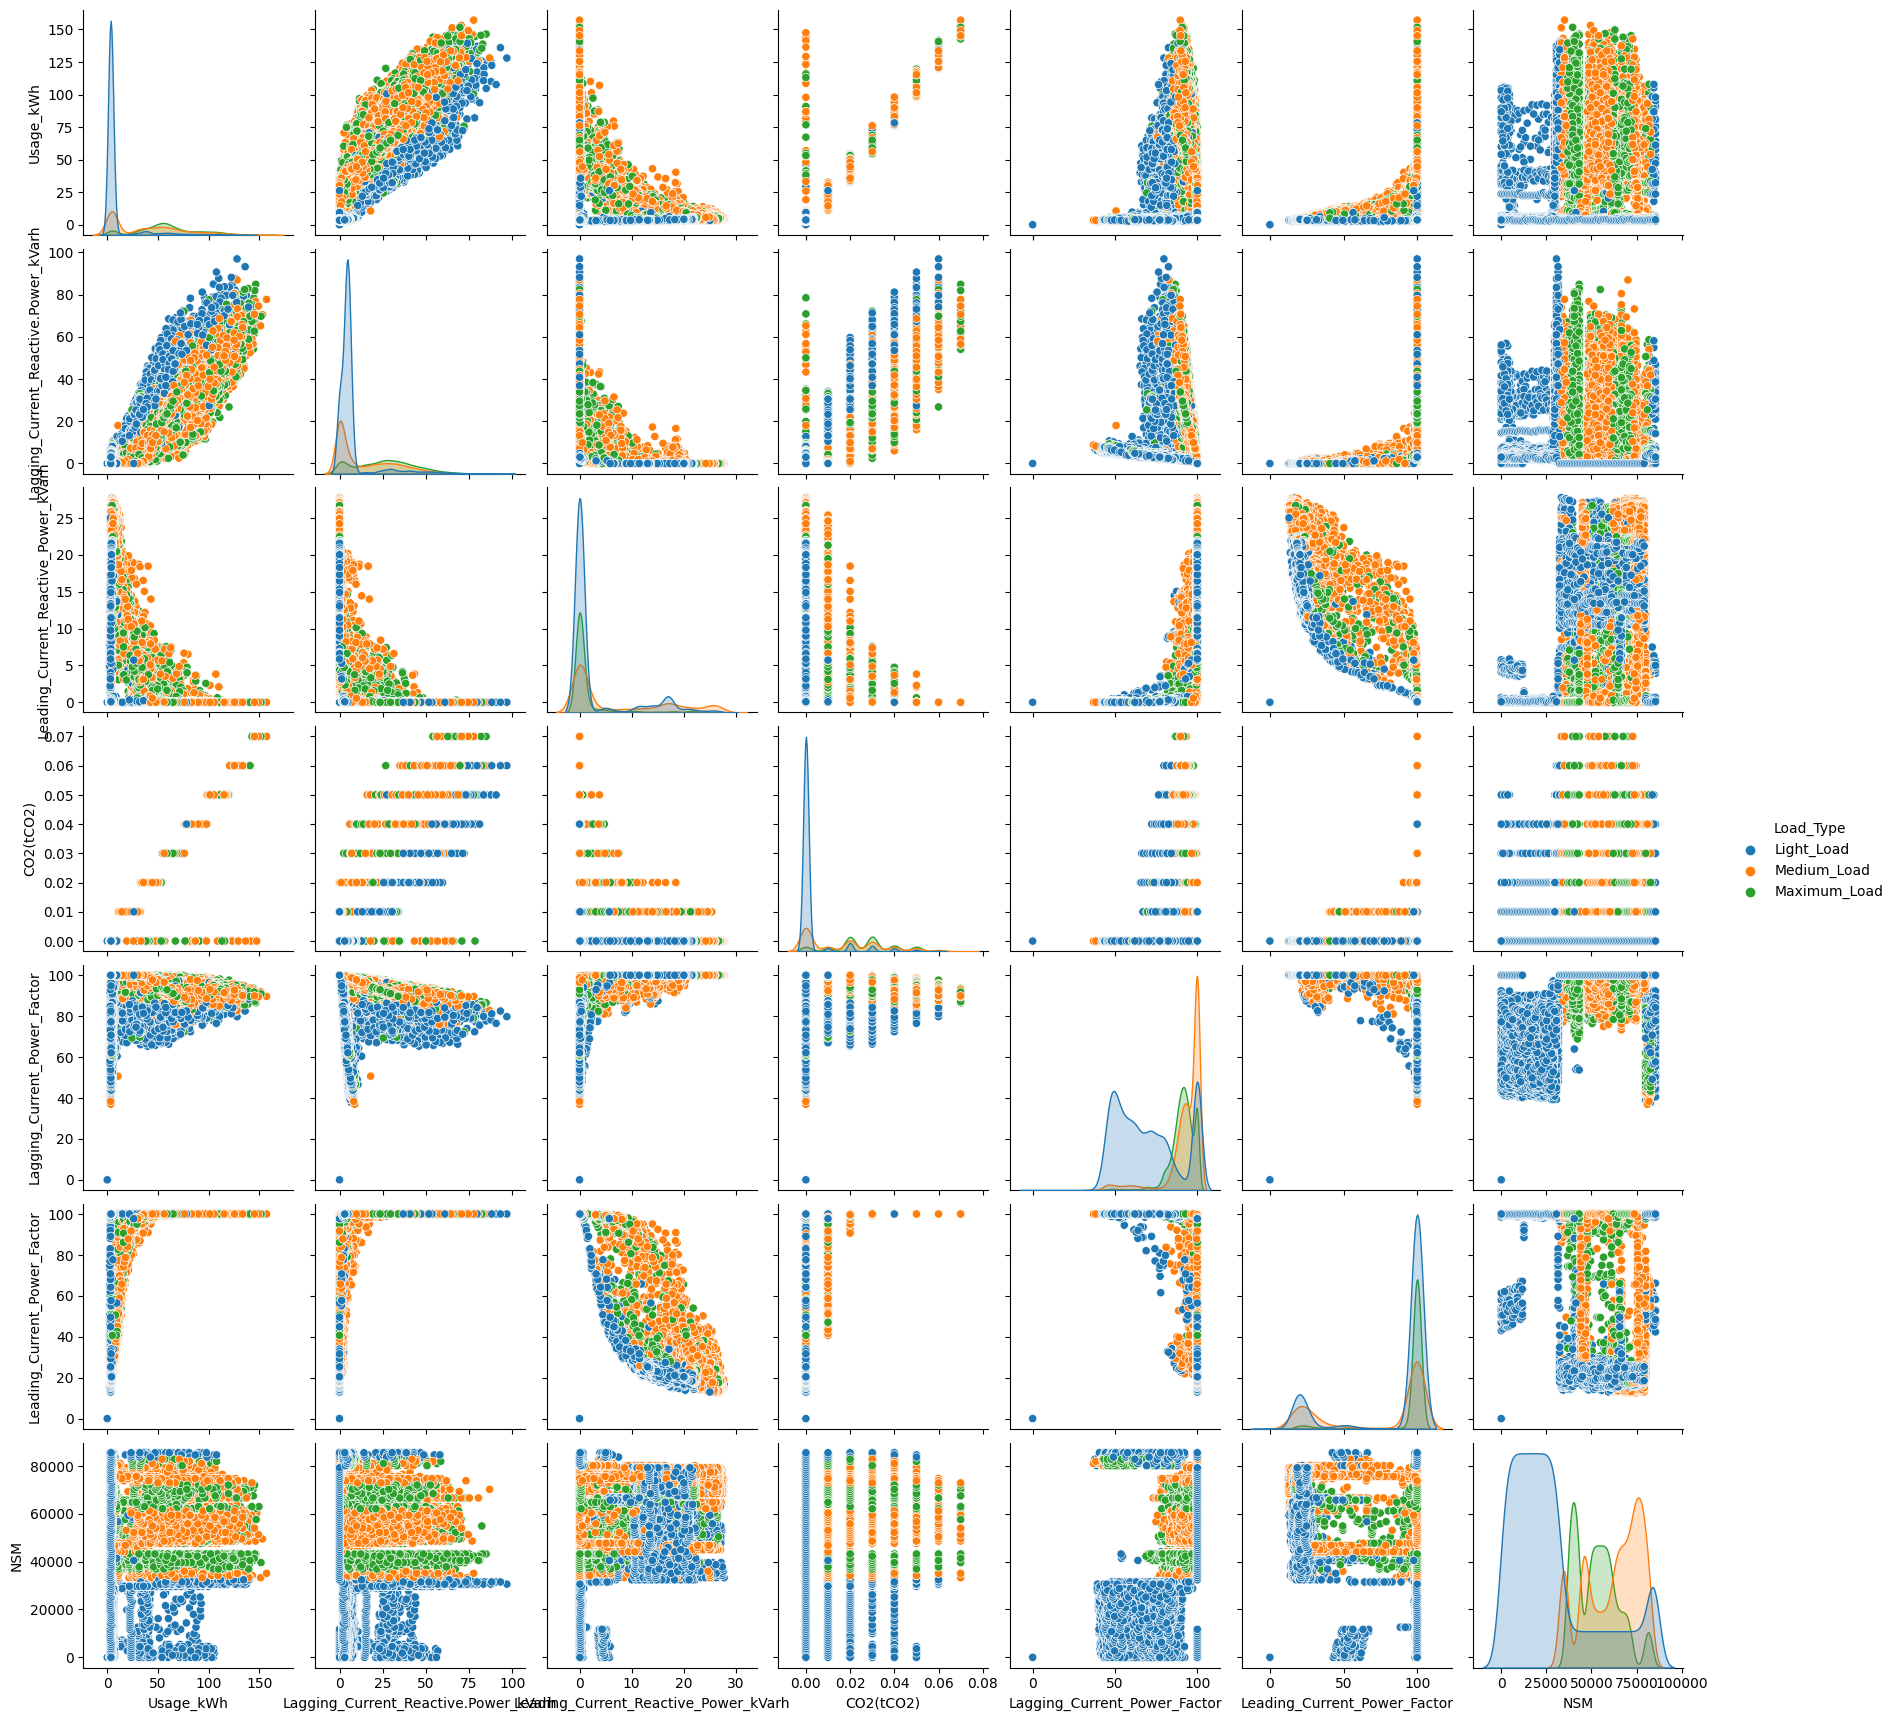

In [ ]:
sns.pairplot(df, hue='Load_Type')

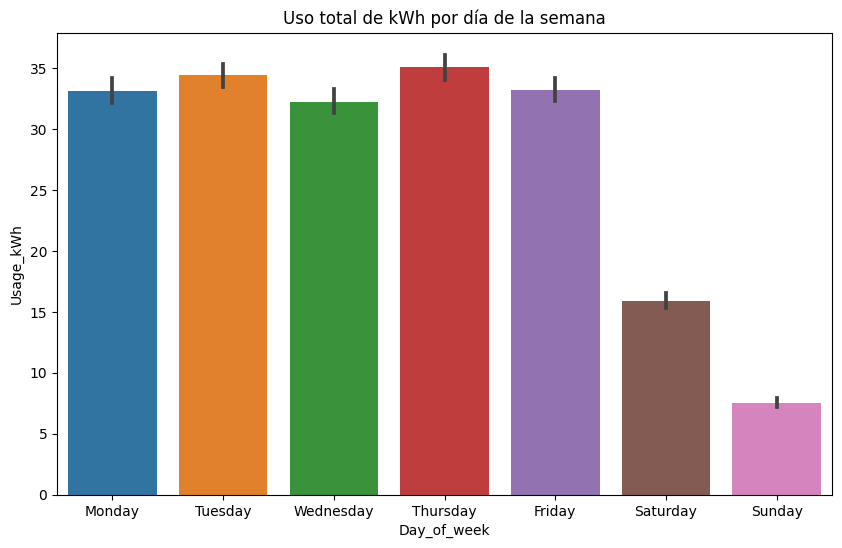

In [ ]:
#Gráficos del EDA
plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_week', y='Usage_kWh', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Uso total de kWh por día de la semana')
plt.show()
### START CODE HERE ###

El consumo evidentemente disminuye los fin de semanas, puede que la industria baja su produccion estos dias.

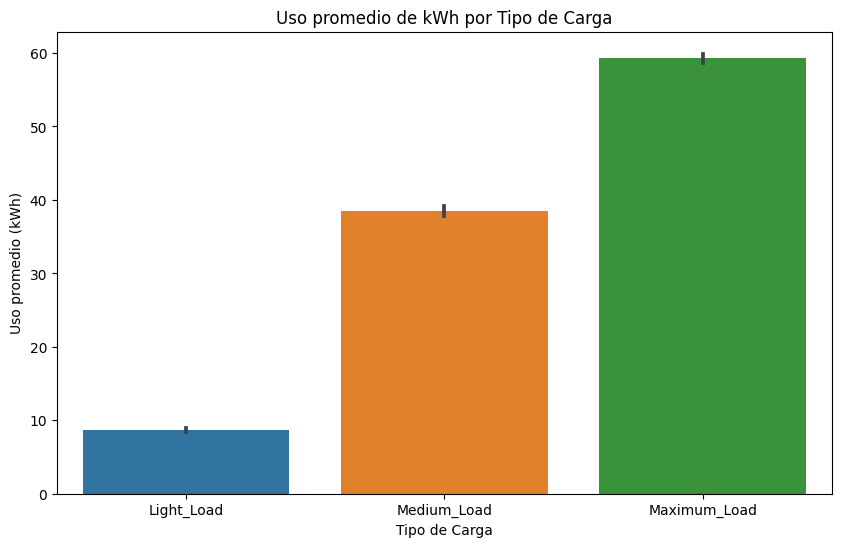

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(x='Load_Type', y='Usage_kWh', data=df)
plt.title('Uso promedio de kWh por Tipo de Carga')
plt.xlabel('Tipo de Carga')
plt.ylabel('Uso promedio (kWh)')
plt.show()

Tiene sentido que la carga liviana requiera un bajo consumo, mientras que una alta carga requiera un mayor consumo.

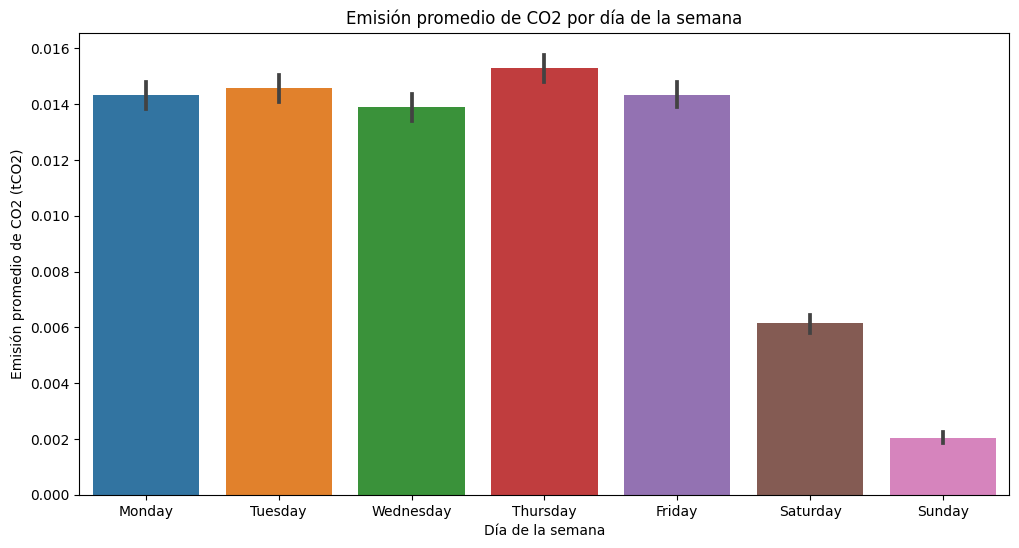

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Day_of_week', y='CO2(tCO2)', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Emisión promedio de CO2 por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Emisión promedio de CO2 (tCO2)')
plt.show()

El jueves es el dia que mas se contamina.

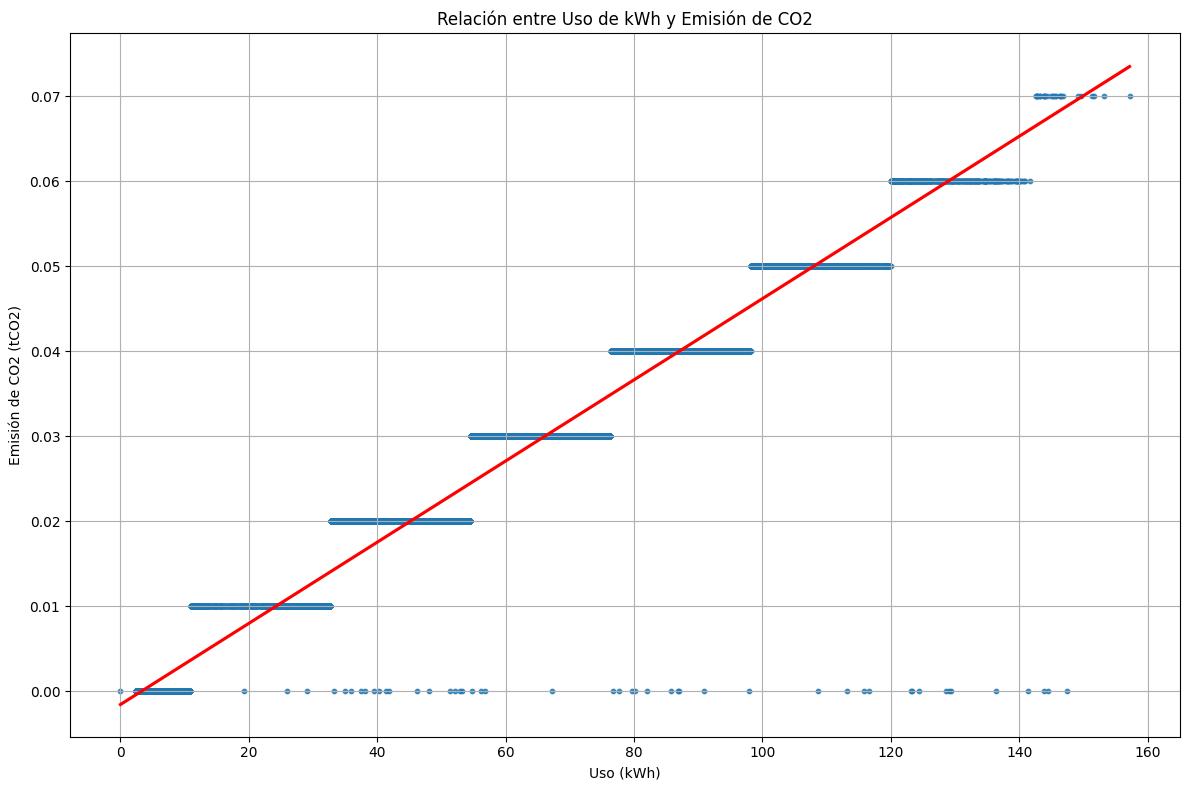

In [ ]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Usage_kWh', y='CO2(tCO2)', data=df, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.title('Relación entre Uso de kWh y Emisión de CO2')
plt.xlabel('Uso (kWh)')
plt.ylabel('Emisión de CO2 (tCO2)')
plt.grid(True)
plt.tight_layout()
plt.show()

Podemos observar datos que existen instancias en las que existe un alto uso de kWh pero no existen emisiones de CO2. Además, al tener un comportamiento escalonado, se puede decir que la precisión de los datos no es la mejor para confirmar si hay una correlación.





### 2.2 Preprocesamiento

El proceso típico de entrenamiento de un modelo consta de dividir la data en 3 conjuntos, uno para entrenamiento, otro para validación y otro para testing

**Defina cuál es la utilidad de cada uno de estos conjuntos e implemente el código para separar la data considerando un split de 80/10/10 respectivamente** [3 Pts]

*80% de la data para entrenamiento, 10% para validación y el 10% para testing*

*Para ello se puede apoyar en la función [train_test_split](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) de scikit-learn.*

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size="size_for_test", random_state=SEED)
```
```
# Using a pandas dataframe
df_train, df_test = train_test_split(df_data, test_size="size_for_test", random_state=SEED)
```

In [ ]:
# Dividir la data considerando el split indicado anteriormente (se recomienda separar en train y test en esta sección, y separar en validación en la sección de entrenamiento)
### START CODE HERE ###
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# Se ejecuta despues porque nos interesa que el train y el test set estén encodeados

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28032 entries, 9284 to 15795
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  28032 non-null  object 
 1   Usage_kWh                             28032 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  28032 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  28032 non-null  float64
 4   CO2(tCO2)                             28032 non-null  float64
 5   Lagging_Current_Power_Factor          28032 non-null  float64
 6   Leading_Current_Power_Factor          28032 non-null  float64
 7   NSM                                   28032 non-null  int64  
 8   WeekStatus                            28032 non-null  object 
 9   Day_of_week                           28032 non-null  object 
 10  Load_Type                             28032 non-null  object 
dtypes: float64(6



*   `Training`: Para ajustar los parametros del modelo
*   `Validation`: Para ajustar hiperparametros
*   `Testing`: Para evaluar el rendimiento del modelo final



### 2.3 Feature Engineering

Feature Engineering se considera un arte porque involucra mucho la creatividad con el conocimiento del dominio del problema. Consiste en el proceso de crear nuevas características o features a partir de otras existentes. En general la idea principal es la de utilizar el conocimiento del contexto del problema o bien del dominio de los datos para aprovechar esa información y crear features que puedan ayudar en el desempeño de un algoritmo, si bien existen técnicas más o menos estándar como lo puede ser normalizar o estandarizar valores numéricos tambien existen otras transformaciones que no son tan simples y varían mucho dependiendo del problema.

[Referencia](https://elitedatascience.com/feature-engineering)

#### Standard Techniques

Como se ha mencionado anteriormente existen técnicas bastante conocidas en la actualidad para abordar el apartado de Feature Engineer donde la mayoría de estas se pueden dividir en dos grandes grupos dependiendo del tipo de datos tengamos:

1.   Variables numéricas
2.   Variables categóricas

#### Numerical values

*   Normalizing: `MinMaxScaler `
*   Standarizing: `StandardScaler`

#### Categorical values

*   `One-Hot Encoding.`
*   `Ordinal Encoding.`
*   `Label Encoding.`





**Observe el siguiente código y comente cuál podría ser su utilidad para una variable relacionada con fechas, como lo puede ser un día** [2 Pts]

In [ ]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [ ]:
# Crear un dataframe de muestra y aplicar la función
df_day = pd.DataFrame(data=np.arange(1, 366), columns=["day"])
df_day = preprocess_time(df_day, "day", 365)
df_day.head()

,sin_day,cos_day
0,0.017213,0.999852
1,0.034422,0.999407
2,0.051620,0.998667
3,0.068802,0.997630
4,0.085965,0.996298


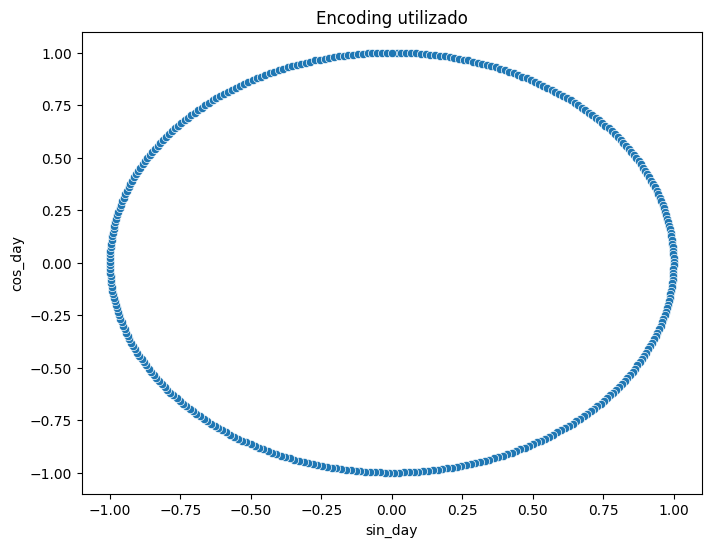

In [ ]:
# Mostrar la transformación aplicada
fig = plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_day, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

`Respuesta`: La utilidad es que podemos enseñarle a una red el comportamiento cíclico de una variable como lo puede ser la fecha, especificamente el dia, el mes o el año.

**Defina o explique la transformación que aplica cada uno de los siguientes encoding e indique la diferencia entre ellos considerando sklearn** [3 Pts]




*   `One-Hot Encoding`: Transforma cada valor categórico de una característica en una nueva característica binaria, esto es 0 o 1, obteniendo un vector con el indice del valor representado igual a 1 y el resto 0.
```python
OneHotEncoder #Para sklearn
```

*   `Ordinal Encoding`: Transforma valores categóricos en valores enteros, donde el orden de los números refleja algún tipo de orden inherente de las categorías.
```python
OrdinalEncoder #Para sklearn
```
*   `Label Encoding`:Transforma valores categóricos en valores enteros, donde cada valor categórico recibe un número entero único, pero sin un orden específico.
```python
LabelEncoder #Para sklearn
```


**Aplique las siguientes técnicas de preprocesamiento para cada feature especificado:** [3 Pts]

*   `MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`
*   `StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`
*   `Ordinal Encoding`: `Load_Type`
*   `One-Hot Encoding`: `WeekStatus`
*   `Label Encoding`: `Day_of_week`

Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [ ]:
df.tail()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load
35039,31/12/2018 00:00,3.67,3.02,0.07,0.0,77.22,99.98,0,Weekday,Monday,Light_Load


In [ ]:
# preprocesamiendo indicado
### START CODE HERE ###

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder

# MinMaxScaler
min_max_scaler = MinMaxScaler((0, 1))
df[['CO2(tCO2)', 'NSM']] = min_max_scaler.fit_transform(df[['CO2(tCO2)', 'NSM']])

# StandardScaler
standard_scaler = StandardScaler()
df[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']] = standard_scaler.fit_transform(df[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']])

# Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
df['Load_Type'] = ordinal_encoder.fit_transform(df[['Load_Type']])

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(df[['WeekStatus']])

df = pd.concat([df, pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['WeekStatus']))], axis=1)
df = df.drop(['WeekStatus'], axis = 1)
# Label Encoding
label_encoder = LabelEncoder()
df['Day_of_week'] = label_encoder.fit_transform(df['Day_of_week'])





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Convertir la columna date a datetime
df['date'] = pd.to_datetime(df['date'])

# Extraer día, mes y hora
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['hour'] = df['date'].dt.hour

# Función de transformación cíclica
def apply_cyclic_transformation(df, column, period):
    df['sin_' + column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_' + column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

# Aplicar transformación cíclica
df = apply_cyclic_transformation(df, 'day', 30)
df = apply_cyclic_transformation(df, 'month', 12)
df = apply_cyclic_transformation(df, 'hour', 24)
df = df.drop(['date'], axis=1)

In [ ]:
import math
def angulo_del_circulo_unitario(seno, coseno):
    angulo_radianes = math.atan2(seno, coseno)
    angulo_grados = math.degrees(angulo_radianes)
    return angulo_grados
print(angulo_del_circulo_unitario(-0.258819,0.965926	))
df.info()

-14.999994927869734
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  float64
 7   Day_of_week                           35040 non-null  int64  
 8   Load_Type                             35040 non-null  float64
 9   WeekStatus_Weekend                    35040 non-null  float64
 10  sin_day                               35040 non-null  float64


### 2.4 Datos a predecir

Una vez teniendo nuestro dataset preprocesado toca crear un modelo de redes neuronales para predecir, para esto vamos a separar nuestro vector de entrada de la columna a predecir

In [ ]:
# Separar la columna a predecir "Usage_kWh" y los datos para entrenar
### START CODE HERE ###
from sklearn.model_selection import train_test_split
X = df.drop("Usage_kWh", axis=1).values
y = df["Usage_kWh"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X_train.shape[1]

15

### 2.5 Mi primera Red Neuronal

Ahora procederemos a crear nuestro modelo con Keras, aca queda a libre elección si quieren utilizar la API secuencial o funcional, y tambien queda a libre elección la arquitectura de la red, pruebe con distintas capas, distinto número de neuronas, distintas funciones de activación, regularizadores, etc.

In [ ]:
#Crear un modelo de Keras a libre elección
### START CODE HERE ###
inputs = keras.layers.Input(shape=(X_train.shape[1],))
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(inputs)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
output = keras.layers.Dense(1, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 15)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 256)               │      4,096 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_6 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_22 (Dense)                │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_7 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_23 (Dense)                │ (None, 32)                │      4,128 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_24 (Dense)                │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 41,153 (160.75 KB)

 Trainable params: 41,153 (160.75 KB)

 Non-trainable params: 0 (0.00 B)

**Siendo un problema de regresión, ¿cuántas neuronas en la capa de salida tiene que tener nuestro modelo? y con que activación? [3pts]**

`Respuesta`: Es necesaria 1 neurona, ya que en la capa de salida la cantidad de neuronas corresponden a cada feature a predecir. La regresion lineal requiere activación lineal.


Ahora vamos a compilar y entrenar nuestro modelo, si quiere ponerse más creativo en esta sección puede implementar callbacks, probar distintos optimizadores, batch_size y epochs.

In [ ]:
### START CODE HERE ###
loss = keras.losses.MeanSquaredError()
opt= keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

In [ ]:
### START CODE HERE ###
epochs = 200
batch_size = 128

val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

### 2.6 Entrenando el Modelo

In [ ]:
### START CODE HERE ###
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 704.5464 - mean_absolute_error: 15.7013 - mean_squared_error: 704.5464 - root_mean_squared_error: 25.3797 - val_loss: 34.2948 - val_mean_absolute_error: 3.1972 - val_mean_squared_error: 34.2948 - val_root_mean_squared_error: 5.8564
Epoch 2/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39.3006 - mean_absolute_error: 3.5780 - mean_squared_error: 39.3006 - root_mean_squared_error: 6.2585 - val_loss: 15.3741 - val_mean_absolute_error: 2.0559 - val_mean_squared_error: 15.3741 - val_root_mean_squared_error: 3.9214
Epoch 3/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.2717 - mean_absolute_error: 2.8906 - mean_squared_error: 25.2717 - root_mean_squared_error: 5.0255 - val_loss: 11.2777 - val_mean_absolute_error: 1.8300 - val_mean_squared_error: 11.2777 - val_root_mean_squared_error: 3.3588
Epoch 4/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.0755 - mean_absolute_error: 2.7092 - mean_squared_error: 22.0755

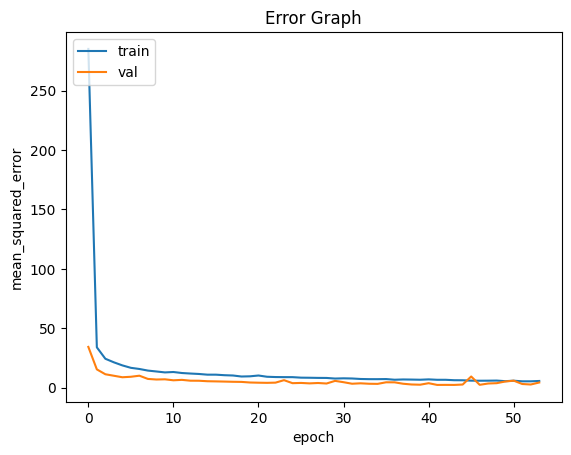

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.234745740890503
Test accuracy: 0.8661186695098877


### 2.7 Exportar y guardar el Modelo

Por último, una vez entrenado nuestro modelo es importante guardarlo, para esto utilizaremos la función `save_model` de keras

In [ ]:
model.save('steel_ind_regression.keras')

Para la entrega de la tarea, el modelo creado tiene que ser subido junto al jupyter notebook completado al github, ya sea en .keras o en un archivo .zip, el modelo será cargado y evaluado para comprobar su correcto funcionamiento, se recomienda probar el guardar y cargar el modelo en el mismo notebook para verificar que no hayan errores.